### Read Public Groups/Pages classify groups by State
### Topic Modeling 

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [4]:
import os
os.getcwd()

'/Users/claudia/Desktop/Latinx2020'

In [5]:

#path = "Latinx2020/"
posts = pd.read_csv("Topics_FB_Political_Posts_per_partyimmigration.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(251, 35)

In [6]:
posts['URL']

0      https://www.facebook.com/LatinosForTrump/posts...
1      https://www.facebook.com/LatinosForTrump/posts...
2      https://www.facebook.com/RealLft2020/posts/179...
3      https://www.facebook.com/Latinos4Biden/posts/1...
4      https://www.facebook.com/groups/17457134490857...
                             ...                        
246    https://www.facebook.com/groups/16117025857872...
247    https://www.facebook.com/groups/16117025857872...
248    https://www.facebook.com/groups/16117025857872...
249    https://www.facebook.com/groups/37168613350092...
250    https://www.facebook.com/groups/51248309636472...
Name: URL, Length: 251, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [7]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [8]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party'],
      dtype='object')

In [9]:
posts["Created"].head(5)

0    2020-09-06 11:03:27 EDT
1    2020-09-14 09:39:35 EDT
2    2020-09-21 01:28:11 EDT
3    2020-10-23 11:27:26 EDT
4    2020-08-29 14:08:11 EDT
Name: Created, dtype: object

In [10]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0     2020-09-06 11:03:27-04:00
1     2020-09-14 09:39:35-04:00
2     2020-09-21 01:28:11-04:00
3     2020-10-23 11:27:26-04:00
4     2020-08-29 14:08:11-04:00
                 ...           
246   2020-10-14 18:45:36-04:00
247   2020-11-03 11:25:28-05:00
248   2020-10-16 20:57:07-04:00
249   2020-09-02 13:54:11-04:00
250   2020-10-30 08:58:55-04:00
Name: converted_date, Length: 251, dtype: datetime64[ns, tzlocal()]

In [53]:
posts['converted_date'] = posts['converted_date'].dt.date

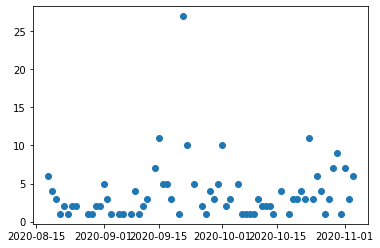

In [54]:
import matplotlib.pyplot as plt
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index()
group_date
plt.scatter(group_date['converted_date'],group_date['Facebook Id'] )
plt.show()

In [12]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date


In [13]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [14]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [15]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

## 3. Which groups are publishing the majority of the content

In [17]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Latinos Against Donald Trump,25
Latinos For Trump -California Group,22
Latinos For Trump.,15
Mexicans for Donald Trump,14
CARA - Cuban American Republican Alliance,11
...,...
American Latinos for freedom! Trump 2020,1
Latinos For Trump Wisconsin,1
Latinos For Trump en Espaol,1


In [18]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (105, 36)
republicans (158, 36)
general politics (5, 36)
none (61,)


35

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [19]:
posts_democrats['MessageDescr'][3:6]

12     According to the “virtuous” Democrats that cr...
14    Ilhan Omar you are a Fraud corrupted criminal!...
21     The difference between me and a lot of my Dem...
Name: MessageDescr, dtype: object

In [20]:
posts_democrats.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party', 'converted_date'],
      dtype='object')

## FB Groups Political Posts

## Tokenize words and Clean-up text

In [23]:
content = posts.copy()
content['MessageDescr']

0      "President Donald J. Trump is bringing back th...
1      President Donald J. Trump: "Our Hispanic-Ameri...
2      Since 2016, Julio de Lima Silva, originally fr...
3      There you go! That man lies, lies, lies. https...
4      “ I raise a Hallelujah, in the presence of my ...
                             ...                        
246    Not yet Eligible to Vote? Your 'adopted' Count...
247     US Judge Blocks Trump Immigration Rule on Pub...
248    Trump could change our Representatives, for ye...
249     IS TRUMP RIGHT?\n.\nDONALD TRUMP: 'NOT ONE EU...
250    They need to do their homework and it's not ab...
Name: MessageDescr, Length: 251, dtype: object

In [24]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(251,)

In [25]:
# Convert to list
data = content.cleanMessage.tolist()

In [26]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [27]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['president', 'donald', 'trump', 'is', 'bringing', 'back', 'the', 'pharmaceutical', 'industry', 'to', 'puerto', 'rico', 'after', 'democrats', 'like', 'joe', 'biden', 'sent', 'our', 'jobs', 'to', 'communist', 'china', 'juan', 'carlos', 'benitez', 'entrepreneur', 'immigration', 'attorney', 'latinosfortrump'], ['president', 'donald', 'trump', 'our', 'hispanic', 'american', 'population', 'wants', 'legal', 'immigration', 'latinosfortrump']]


#### Creating Bigram and Trigram Models

In [28]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['president', 'donald', 'trump', 'is', 'bringing', 'back', 'the', 'pharmaceutical', 'industry', 'to', 'puerto', 'rico', 'after', 'democrats', 'like', 'joe_biden', 'sent', 'our', 'jobs', 'to', 'communist', 'china', 'juan_carlos', 'benitez', 'entrepreneur', 'immigration', 'attorney', 'latinosfortrump']


## Remove Stopwords, Make Bigrams and Lemmatize

In [29]:
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [30]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [31]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [32]:
print(data_words_nostops[1:2])

[['president', 'donald', 'trump', 'hispanic', 'american', 'population', 'wants', 'legal', 'immigration', 'latinosfortrump']]


## Bag of Words

In [33]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [34]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [35]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [36]:
final_dict.most_common(1000)

[('donald / trump', 609),
 ('immigration', 253),
 ('voters / vote / voting', 164),
 ('americo', 120),
 ('president / presidente', 119),
 ('peoplir', 98),
 ('country', 90),
 ('bidir', 89),
 ('border', 82),
 ('immigrant', 78),
 ('americar', 70),
 ('said', 66),
 ('administration', 61),
 ('know', 60),
 ('latino / latinos', 60),
 ('rights', 58),
 ('democrat / democrats', 55),
 ('laws', 54),
 ('election', 52),
 ('illegal', 52),
 ('great', 51),
 ('government', 51),
 ('american / america / americans', 51),
 ('right', 50),
 ('power', 50),
 ('citizen', 49),
 ('way', 49),
 ('dont', 49),
 ('support', 47),
 ('first', 46),
 ('see', 45),
 ('post', 44),
 ('federal', 44),
 ('mexico / mexican', 44),
 ('national', 43),
 ('years', 42),
 ('reform', 41),
 ('time', 41),
 ('new', 40),
 ('back', 39),
 ('votar', 39),
 ('every', 39),
 ('community', 39),
 ('million', 39),
 ('violence', 38),
 ('women', 37),
 ('also', 37),
 ('wall', 37),
 ('justizar', 36),
 ('us', 36),
 ('united_stat', 36),
 ('end', 35),
 ('share',

In [37]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [38]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
print(bow_df)

     aback  abandoned  abiding  abidir  able  abogado  abolished  abolishing  \
0        0          0        0       0     0        0          0           0   
1        0          0        0       0     0        0          0           0   
2        0          0        0       0     0        0          0           0   
3        0          0        0       0     0        0          0           0   
4        0          0        0       0     0        0          0           0   
..     ...        ...      ...     ...   ...      ...        ...         ...   
246      0          0        0       0     0        0          0           0   
247      0          0        0       0     0        0          0           0   
248      0          0        0       0     0        0          0           0   
249      0          0        0       0     0        0          0           0   
250      0          0        0       0     0        0          0           0   

     abominations  abortion  ...  zillo

In [39]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [40]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
immigration,1.182322
trump,1.669617
vote,2.295323
él,2.370546
president,2.386294
...,...
homeowners,5.836282
homes,5.836282
homework,5.836282
honed,5.836282


In [41]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [42]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [43]:
df

,tfidf
attorney,0.213321
back,0.164993
benitez,0.286438
bringing,0.259495
chino,0.213321
communist,0.234706
democrat,0.179007
donald,0.133991
entrepreneur,0.249879
immigration,0.062359


In [44]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts
0,do you know alexander hamilton? would you lik...,3
1,“president donald trump joined rush limbaugh ...,2
2,this just in: the republican national hispan...,2
3,"unfortunately the democrat party, has become ...",2
4,not yet eligible to vote? your 'adopted' count...,1
5,this new report needs to be read beyond the ti...,1
6,"""president donald j. trump is bringing back th...",1
7,"""president donald j. trump is bringing back t...",1
8,"buckle up, this is a long one. \nmy name is c...",1
9,yep. looks like the winning hand for 2020-2024...,1


### Repeated messages

In [57]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

results.to_csv("mostpopularNewsMedia.csv")

In [59]:
results.sort_values(by='Counts',ascending=False)

Counts  \
MessageDescr                                       Link                                                         
 Since 2016, Julio de Lima Silva, originally fr... https://www.facebook.com/RealLft2020/videos/358...      18   
 Do you know Alexander Hamilton? Would you like... https://www.facebook.com/laalternativaverdadera...       3   
 We are fighting for economic freedom and oppor... https://www.facebook.com/photo.php?fbid=2579508...       3   
 Breaking Campaign News. Jeffi Grigenti has rec... https://www.facebook.com/photo.php?fbid=1015896...       3   
This is a main reason why big tech, large corpo... https://www.breitbart.com/immigration/2020/11/0...       2   
...                                                                                                       ...   
 The buffoon in the White House just brokered t... https://www.facebook.com/1407353590/posts/10219...       1   
 The difference between me and a lot of my Demo... https://www.facebook.com/photo.php?fbid=1015125...       1   
 The fee changes would have increased the cost ... https://chicago.suntimes.com/2020/9/29/21494628...       1   
 The whistleblower, Dawn Wooten, worked at the ... https://www.refinery29.com/en-us/2020/09/100246...       1   
🤦‍♂️🤦‍♀️🤡 An example of an uninformed person 🤦‍... https://www.facebook.com/OscarElBlue/photos/a.2...       1   

                                                                                                       Likes  \
MessageDescr                                       Link                                                        
 Since 2016, Julio de Lima Silva, originally fr... https://www.facebook.com/RealLft2020/videos/358...     92   
 Do you know Alexander Hamilton? Would you like... https://www.facebook.com/laalternativaverdadera...      5   
 We are fighting for economic freedom and oppor... https://www.facebook.com/photo.php?fbid=2579508...     41   
 Breaking Campaign News. Jeffi Grigenti has rec... https://www.facebook.com/photo.php?fbid=1015896...      2   
This is a main reason why big tech, large corpo... https://www.breitbart.com/immigration/2020/11/0...      2   
...                                                                                                      ...   
 The buffoon in the White House just brokered t... https://www.facebook.com/1407353590/posts/10219...      0   
 The difference between me and a lot of my Demo... https://www.facebook.com/photo.php?fbid=1015125...     14   
 The fee changes would have increased the cost ... https://chicago.suntimes.com/2020/9/29/21494628...      0   
 The whistleblower, Dawn Wooten, worked at the ... https://www.refinery29.com/en-us/2020/09/100246...      0   
🤦‍♂️🤦‍♀️🤡 An example of an uninformed person 🤦‍... https://www.facebook.com/OscarElBlue/photos/a.2...     11   

                                                                                                       Comments  \
MessageDescr                                       Link                                                           
 Since 2016, Julio de Lima Silva, originally fr... https://www.facebook.com/RealLft2020/videos/358...         5   
 Do you know Alexander Hamilton? Would you like... https://www.facebook.com/laalternativaverdadera...         1   
 We are fighting for economic freedom and oppor... https://www.facebook.com/photo.php?fbid=2579508...         3   
 Breaking Campaign News. Jeffi Grigenti has rec... https://www.facebook.com/photo.php?fbid=1015896...         0   
This is a main reason why big tech, large corpo... https://www.breitbart.com/immigration/2020/11/0...         0   
...                                                                                                         ...   
 The buffoon in the White House just brokered t... https://www.facebook.com/1407353590/posts/10219...         0   
 The difference between me and a lot of my Demo... https://www.facebook.com/photo.php?fbid=1015125...         1   
 The fee changes would hav

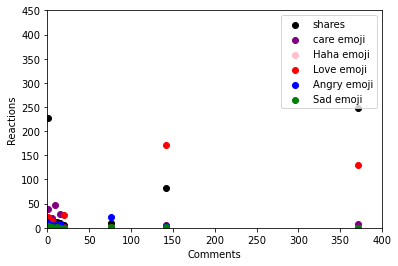

In [47]:
results.reset_index()
plt.xlim(0,400)
plt.ylim(0,450)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


In [48]:
#Topic Modeling
#Create the Dictionary and Corpus needed for Topic Modeling


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]
#Buiding the Topic Model

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]


[[('council', 1),
  ('district', 1),
  ('fees', 1),
  ('immigration', 1),
  ('inmigracion', 1),
  ('nuevo', 1),
  ('nyc', 1),
  ('october', 1),
  ('octubre', 1),
  ('partir', 1),
  ('starting', 1),
  ('tarifa', 1)]]

In [49]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [50]:
#View the topics in LDA model
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.005*"loui" + 0.000*"trump" + 0.000*"hispanic" + 0.000*"veterans" + '
  '0.000*"florido" + 0.000*"bidir" + 0.000*"issu" + 0.000*"immigration" + '
  '0.000*"americo" + 0.000*"hear"'),
 (1,
  '0.026*"without" + 0.022*"director" + 0.020*"joe_bidir" + 0.019*"medio" + '
  '0.017*"bidir" + 0.015*"died" + 0.013*"come" + 0.013*"attorney" + '
  '0.011*"full" + 0.010*"heads"'),
 (2,
  '0.026*"president" + 0.025*"ofa" + 0.016*"country" + 0.014*"administration" '
  '+ 0.013*"organizing" + 0.012*"destroy" + 0.010*"laws" + 0.009*"support" + '
  '0.009*"action" + 0.008*"protest"'),
 (3,
  '0.030*"peoplir" + 0.018*"government" + 0.015*"laws" + 0.014*"also" + '
  '0.013*"country" + 0.012*"democracy" + 0.012*"republic" + 0.011*"people" + '
  '0.010*"dont" + 0.009*"majority"'),
 (4,
  '0.139*"trump" + 0.036*"immigration" + 0.021*"donald" + 0.020*"president" + '
  '0.014*"election" + 0.014*"americo" + 0.010*"border" + 0.010*"see" + '
  '0.009*"great" + 0.009*"post"'),
 (5,
  '0.026*"good" + 0.017

In [51]:
#Compute Model Perplexity and Coherence Score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.914830330118964

Coherence Score:  0.400450166434889


In [52]:
#Visualize the topics-keywords
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.246588 -0.028605       1        1  18.503251
15     0.114016 -0.291223       2        1  11.512615
9      0.133572  0.099766       3        1  10.964923
3      0.121338  0.139390       4        1   8.060315
16     0.200598  0.017616       5        1   6.902794
2      0.149834  0.114383       6        1   6.439873
18     0.008891 -0.123326       7        1   6.068140
5     -0.015823 -0.033133       8        1   5.409771
12    -0.012630  0.043303       9        1   4.004937
8      0.019357 -0.037016      10        1   3.756598
17    -0.083641  0.016501      11        1   3.564406
6     -0.077013  0.044606      12        1   3.032703
1     -0.112580 -0.003679      13        1   2.711972
11    -0.104978  0.028882      14        1   2.432889
10    -0.082031 -0.053995      15        1   2.047821
19    -0.096348  0.004372      16        1   1.992236
14    -0.082127  0.051511      17        1   1.844441
7     -0.113255  0.003239      18        1   0.397627
13    -0.109638  0.004367      19        1   0.318001
0     -0.104129  0.003040      20        1   0.034687, topic_info=             Term        Freq       Total Category  logprob  loglift
19          trump  600.000000  600.000000  Default  30.0000  30.0000
33           vote   93.000000   93.000000  Default  29.0000  29.0000
9     immigration  264.000000  264.000000  Default  28.0000  28.0000
15      president  135.000000  135.000000  Default  27.0000  27.0000
933       peoplir  113.000000  113.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
71       military    0.001363   17.044076  Topic20  -8.5783  -1.4673
1669         join    0.001363   12.812079  Topic20  -8.5783  -1.1819
852         first    0.001363   55.358981  Topic20  -8.5783  -2.6453
125          call    0.001363   29.085062  Topic20  -8.5783  -2.0017
1421         wall    0.001363   34.451343  Topic20  -8.5783  -2.1710

[1036 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
340       5  0.324700      él él
340       9  0.568225      él él
1214      4  0.404768   abortion
1214     11  0.485722   abortion
2177      2  0.804096     access
...     ...       ...        ...
260       6  0.150849      years
260      10  0.056568      years
260      16  0.037712      years
2635      6  0.924594  years_ago
1665      5  0.900588         ón

[1400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 16, 10, 4, 17, 3, 19, 6, 13, 9, 18, 7, 2, 12, 11, 20, 15, 8, 14, 1])